# Feature engineering and first models for Diabetes dataset

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from feature_engine.selection import SelectBySingleFeaturePerformance
from sklearn.metrics import accuracy_score, roc_auc_score

In [10]:
data = pd.read_csv("data/diabetes_012_health_indicators_BRFSS2015.csv")

In [11]:
data.info(verbose = False, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Columns: 22 entries, Diabetes_012 to Income
dtypes: float64(22)
memory usage: 42.6 MB


In [16]:
data["Diabetes_012"] = data["Diabetes_012"].astype('int8')
data["HighBP"] = data["HighBP"].astype('int8')
data["HighChol"] = data["HighChol"].astype('int8')
data["CholCheck"] = data["CholCheck"].astype('int8')
data["BMI"] = data["BMI"].astype('int8')
data["Smoker"] = data["Smoker"].astype('int8')
data["Stroke"] = data["Stroke"].astype('int8')
data["HeartDiseaseorAttack"] = data["HeartDiseaseorAttack"].astype('int8')
data["PhysActivity"] = data["PhysActivity"].astype('int8')
data["Fruits"] = data["Fruits"].astype('int8') 
data["Veggies"] = data["Veggies"].astype('int8')
data["HvyAlcoholConsump"] = data["HvyAlcoholConsump"].astype('int8')
data["AnyHealthcare"] = data["AnyHealthcare"].astype('int8')
data["NoDocbcCost"] = data["NoDocbcCost"].astype('int8')
data["GenHlth"] = data["GenHlth"].astype('int8')
data["MentHlth"] = data["MentHlth"].astype('int8')
data["PhysHlth"] = data["PhysHlth"].astype('int8')
data["DiffWalk"] = data["DiffWalk"].astype('int8')
data["Sex"] = data["Sex"].astype('int8')
data["Age"] = data["Age"].astype('int8')
data["Education"] = data["Education"].astype('int8')
data["Income"] =data["Income"].astype('int8')

In [17]:
data.info(verbose = False, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Columns: 22 entries, Diabetes_012 to Income
dtypes: int8(22)
memory usage: 5.3 MB


### Remove outliers from BMI

In [18]:
df_filtered = data.copy(deep=True)

# Identify outliers for BMI
Q1 = df_filtered['BMI'].quantile(0.25)
Q3 = df_filtered['BMI'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers for BMI
outliers_bmi = (df_filtered['BMI'] < lower_bound) | (df_filtered['BMI'] > upper_bound)

# Replace outliers with the last valid value
last_valid_bmi = df_filtered['BMI'][~outliers_bmi].iloc[-1]
df_filtered.loc[outliers_bmi, 'BMI'] = last_valid_bmi

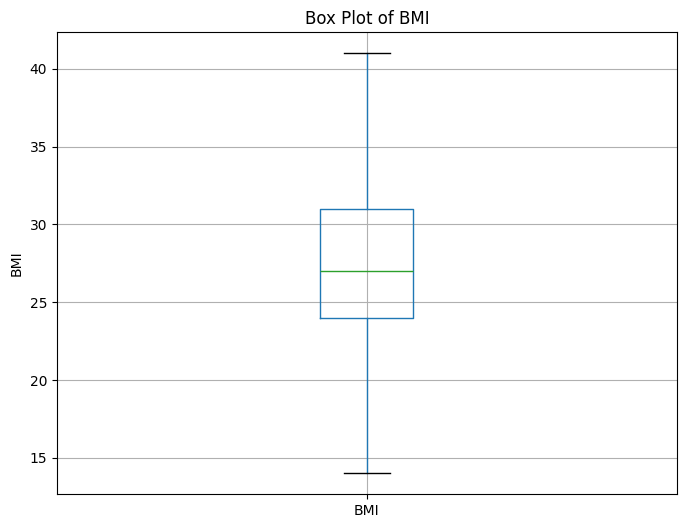

In [5]:
plt.figure(figsize=(8, 6))
df_filtered.boxplot(column=['BMI'])
plt.title('Box Plot of BMI')
plt.ylabel('BMI')
plt.show()

### Binning of PhysHlth and MentHlth

In [19]:
df_filtered["PhysHlth"] = pd.cut(df_filtered["PhysHlth"],
bins=[-np.inf, 5., 10., 15., 20., 25., np.inf],
labels=[1, 2, 3, 4, 5, 6])

In [20]:
df_filtered["PhysHlth"].value_counts()

1    206863
6     20305
2     12451
3      8209
4      3655
5      2197
Name: PhysHlth, dtype: int64

In [21]:
df_filtered["MentHlth"] = pd.cut(df_filtered["MentHlth"],
bins=[-np.inf, 5., 10., 15., 20., 25., np.inf],
labels=[1, 2, 3, 4, 5, 6])

In [22]:
df_filtered["MentHlth"].value_counts()

1    217472
6     12697
2     11191
3      7152
4      3619
5      1549
Name: MentHlth, dtype: int64

### Remove prediabetes from dataset

In [23]:
df_filtered_binary = df_filtered[(df_filtered["Diabetes_012"] == 0) | (df_filtered["Diabetes_012"] == 2)]

In [24]:
# train_set, v_t_set = train_test_split(
# df_filtered_binary, test_size=0.3, stratify=df_filtered_binary["Diabetes_012"], random_state=42)

# validation_set, test_set = train_test_split(
# v_t_set, test_size=0.3, stratify=v_t_set["Diabetes_012"], random_state=42)

#validation_set.to_csv("data/validation_set.csv", index=False)
#test_set.to_csv("data/test_set.csv", index = False)
#train_set.to_csv("data/train_set.csv", index = False)

### Scale columns to [0,1]

In [25]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

In [26]:
train_binary_scaled = pd.DataFrame(min_max_scaler.fit_transform(train_set.values), columns=train_set.columns, index=train_set.index)

In [27]:
test_binary_scaled = pd.DataFrame(min_max_scaler.transform(test_set.values), columns=test_set.columns, index=test_set.index)

In [28]:
train_binary_scaled.describe().loc[("max", "min"), :]

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
X_train = train_binary_scaled.loc[:, train_binary_scaled.columns != 'Diabetes_012']
y_train = train_binary_scaled["Diabetes_012"]

X_test = test_binary_scaled.loc[:, test_binary_scaled.columns != 'Diabetes_012']
y_test = test_binary_scaled["Diabetes_012"]

### First models

KNeighborsClassifier

In [34]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='cosine', metric_params=None, n_jobs=None)
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='euclidean', metric_params=None, n_jobs=None)

# knn.fit(X_train, y_train)
y_predicted = knn.predict(X_test)

print('R^2 score: ', knn.score(X_test, y_test)) # R^2 score - how much better the model is than a mean
print('Accuracy score: ', accuracy_score(y_test, y_predicted))

KeyboardInterrupt: 

RandomForestClassifier

In [31]:
# Random forest model focusing on sensitivity. Gini impurity criterion for choosing the best split nodes
rf = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, min_samples_leaf=1,  bootstrap=True )
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8531786749944233

LogisticRegression

In [54]:
log_reg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight='balanced', random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
log_reg.fit(X_train, y_train)

# Show  coefficients foir each feature and score
coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(log_reg.coef_))], axis = 1)
log_reg.score(X_test, y_test),coefficients


(0.7325451706446576,
                        0         0
 0                 HighBP  0.785034
 1               HighChol  0.593697
 2              CholCheck  1.365527
 3                    BMI  2.310342
 4                 Smoker -0.020093
 5                 Stroke  0.125069
 6   HeartDiseaseorAttack  0.264241
 7           PhysActivity -0.084184
 8                 Fruits -0.065233
 9                Veggies -0.028084
 10     HvyAlcoholConsump -0.807531
 11         AnyHealthcare  0.052325
 12           NoDocbcCost  0.030956
 13               GenHlth  2.381619
 14              MentHlth -0.069418
 15              PhysHlth -0.197778
 16              DiffWalk  0.216182
 17                   Sex  0.251618
 18                   Age  1.591992
 19             Education -0.206617
 20                Income -0.436969)

Wnioski:
- dla modelu dużą wartość mają kolumny BMI, GenHlth, Age, CholCheck (?), HighBP, Income, HvyAlcoholConsump
- okazuje się, że osoby pijące więcej alkoholu mogą mieć mniejszą szansę na cukrzycę typu 2 (ujemny współczynnik), co może mieć związek z tym, że alkohol podczas trawienia pobudza hormony trawienne wydzielane z trzustki (która jest odpowiedzialna za sekrecję insuliny)

### Feature selection

In [61]:
# Removing columns that have coeffictients < 0.1
threshold_to_drop = 0.1
cols_to_drop = X_train.columns[np.where(abs(log_reg.coef_) < threshold_to_drop)[1]]
cols_to_drop

# Sprawdzenie, czy kolumny istnieją w zbiorach danych, zanim zostaną usunięte
X_train_filtered = X_train.drop(columns=cols_to_drop, errors='ignore')
X_test_filtered = X_test.drop(columns=cols_to_drop, errors='ignore')

Feature Selection using RandomForestClassifier 

In [33]:
selector = SelectBySingleFeaturePerformance(
    estimator=RandomForestClassifier(random_state=1),
    scoring='roc_auc',
    cv=3,
    threshold=0.55,
)

In [41]:
X_sm = X_train.head(1000)
y_sm = y_train.head(1000)
X_t_sm = X_test.head(100)
y_t_sm = y_test.head(100)

In [47]:
X_train_filtered_RF = selector.fit_transform(X_sm, y_sm)
X_test_filtered_RF = selector.transform(X_t_sm)

In [48]:
X_train_filtered_RF

,HighBP,HighChol,BMI,HeartDiseaseorAttack,PhysActivity,GenHlth,PhysHlth,DiffWalk,Age,Education,Income
0,1.0,0.0,0.407407,0.0,1.0,0.25,0.0,0.0,0.833333,1.0,1.000000
1,0.0,0.0,0.703704,0.0,1.0,0.50,0.0,0.0,0.500000,0.6,1.000000
2,1.0,0.0,0.703704,0.0,1.0,0.75,0.0,0.0,0.583333,0.6,0.285714
3,1.0,1.0,0.444444,1.0,1.0,0.50,0.0,1.0,0.916667,1.0,0.285714
4,1.0,1.0,0.777778,0.0,0.0,0.75,0.2,1.0,0.833333,0.2,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,1.0,0.592593,0.0,1.0,0.50,0.0,0.0,0.166667,0.8,0.428571
996,0.0,0.0,0.407407,0.0,1.0,0.25,1.0,0.0,0.583333,0.8,0.285714
997,0.0,1.0,0.592593,0.0,0.0,0.75,0.6,0.0,0.500000,0.8,0.857143
998,0.0,0.0,0.370370,0.0,1.0,0.25,0.0,0.0,0.083333,1.0,1.000000


In [54]:
log_reg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight='balanced', random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
log_reg.fit(X_train_filtered_RF, y_sm)
y_predict = log_reg.predict(X_test_filtered_RF)

# Show coefficients foir each feature
coefficients = pd.concat([pd.DataFrame(X_train_filtered_RF.columns),pd.DataFrame(np.transpose(log_reg.coef_))], axis = 1)
log_reg.score(X_test_filtered_RF, y_t_sm), roc_auc_score(y_t_sm, y_predict), coefficients

(0.65,
 0.5852272727272727,
                        0         0
 0                 HighBP  0.739039
 1               HighChol  1.117945
 2                    BMI  1.037604
 3   HeartDiseaseorAttack  0.333713
 4           PhysActivity -0.547710
 5                GenHlth  1.688975
 6               PhysHlth -0.432565
 7               DiffWalk  0.404047
 8                    Age  0.825262
 9              Education -0.817793
 10                Income -0.368471)

### Check the difference

In [62]:
# Without unnecessary columns
log_reg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight='balanced', random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
log_reg.fit(X_train_filtered, y_train)

# Show coefficients foir each feature
coefficients = pd.concat([pd.DataFrame(X_train_filtered.columns),pd.DataFrame(np.transpose(log_reg.coef_))], axis = 1)
log_reg.score(X_test_filtered, y_test),coefficients

(0.7308944902966763,
                        0         0
 0                 HighBP  0.786605
 1               HighChol  0.594748
 2              CholCheck  1.360414
 3                    BMI  2.331567
 4                 Stroke  0.124932
 5   HeartDiseaseorAttack  0.261927
 6      HvyAlcoholConsump -0.807228
 7                GenHlth  2.396305
 8               PhysHlth -0.202542
 9               DiffWalk  0.228379
 10                   Sex  0.254787
 11                   Age  1.590446
 12             Education -0.235100
 13                Income -0.441527)

Wnioski:
- regresja logistyczna daje nieco mniejszy wskaźnik accuracy po wyeliminowaniu najmniej znaczących kolumn

### Evaluate Logistic Regression model

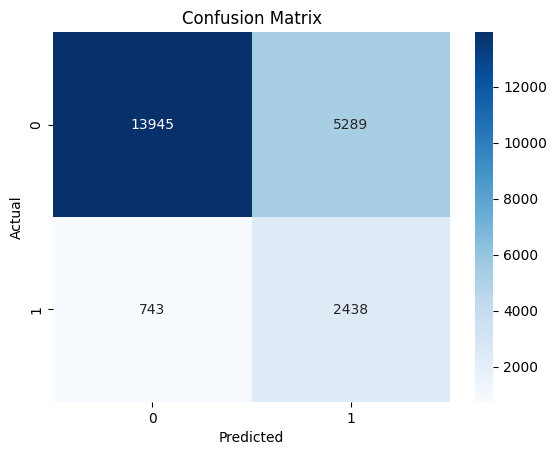

In [64]:
# For output of  Logistic Regression
from sklearn.metrics import confusion_matrix
y_pred = log_reg.predict(X_test_filtered)
# confusion_matrix(y_test, y_pred)

import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


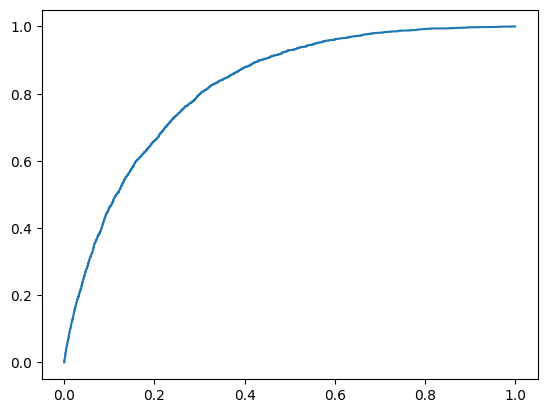

In [66]:
# ROC for Logistic Regression
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, log_reg.predict_proba(X_test_filtered)[:,1]))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test_filtered)[:,1])
plt.plot(fpr, tpr)


### Danger zone

In [25]:
#now please prepare me basic grid search for knn, logistic regression and random forest
#knn
# knn_params = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
# knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, n_jobs=-1)
# knn_grid.fit(X_train, y_train)
# knn_grid.best_params_

KeyboardInterrupt: 

In [18]:
# Define hyperparameters for Logistic Regression
# logistic_regression_params = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Regularization parameter
#     'solver': ['lbfgs', 'saga'],  # Solver for optimization problem
#     'penalty': ['l1', 'l2']  # Regularization penalty
# }

# Define hyperparameters for k-Nearest Neighbors
# knn_params = {
#     'n_neighbors': list(range(1, 31)),  # Number of neighbors
#     'weights': ['uniform', 'distance'],  # Weight function used in prediction
#     'metric': ['euclidean', 'manhattan']  # Distance metric
# }

# Define hyperparameters for Random Forest
# random_forest_params = {
#     'n_estimators': [50, 100, 200],  # Number of trees in the forest
#     'max_depth': [10, 20, 30, None],  # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
#     'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
# }

# Perform grid search for Logistic Regression
# grid_search_logistic = GridSearchCV(LogisticRegression(), logistic_regression_params, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
# grid_search_logistic.fit(X_train, y_train)

# Perform grid search for k-Nearest Neighbors
# grid_search_knn = GridSearchCV(KNeighborsClassifier(), knn_params, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
# grid_search_knn.fit(X_train, y_train)

# Perform grid search for Random Forest
# grid_search_rf = GridSearchCV(RandomForestClassifier(), random_forest_params, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
# grid_search_rf.fit(X_train, y_train)

# Print best parameters and corresponding scores for each classifier
# print("Best parameters for Logistic Regression:")
# print(grid_search_logistic.best_params_)
# print("Best cross-validation accuracy score for Logistic Regression: {:.2f}".format(grid_search_logistic.best_score_))

# print("Best parameters for k-Nearest Neighbors:")
# print(grid_search_knn.best_params_)
# print("Best cross-validation accuracy score for k-Nearest Neighbors: {:.2f}".format(grid_search_knn.best_score_))

# print("Best parameters for Random Forest:")
# print(grid_search_rf.best_params_)
# print("Best cross-validation accuracy score for Random Forest: {:.2f}".format(grid_search_rf.best_score_))



Fitting 5 folds for each of 120 candidates, totalling 600 fits


KeyboardInterrupt: 